In [0]:
!pip3 install simpy

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple


In [0]:
import itertools
import random

import simpy

# Gas Station

* Carros chegam ao posto de gasolina em intervalos de tempo aleatórios entre (uniforme) 30 e 300 segundos

In [0]:
T_INTER = [30, 300]        # Create a car every [min, max] seconds

 * Os carros tem o mesmo tamanho de tanque de 50 litros

In [0]:
FUEL_TANK_SIZE = 50        # liters

* Os carros chegam no posto ainda com certa quantidade aleatória de gasolina, entre 5 e 25 (uniforme) litros

In [0]:
FUEL_TANK_LEVEL = [5, 25]  # Min/max levels of fuel tanks (in liters)

A velocidade de reabastecimento é de 2 litros por segundo

In [0]:
REFUELING_SPEED = 2        # liters / second

 * O tamanho do tanque central de gasolina é de 200 litros

In [0]:
GAS_STATION_SIZE = 200     # liters

 * O caminhão de gasolina demora 300 segundos para chegar e completar o tanque central

In [0]:
TANK_TRUCK_TIME = 300      # Seconds it takes the tank truck to arrive

### Você pode decidir

 * quantas bombas de gasolina deixa abertas?

In [0]:
NUM_FUEL_PUMPS = 2         # Number of fuel pumps opened

 * Em qual porcentagem da capacidade do tanque central que você chamará o caminhão tanque?

In [0]:
THRESHOLD = 10             # Threshold for calling the tank truck (in %)

## Vamos simular

 * por 1000 segundos

In [0]:
SIM_TIME = 1000            # Simulation time in seconds

 * com a raíz aleatória 42, para que os resultados sejam reproduzíveis

In [0]:
RANDOM_SEED = 42

### Um carro chega ao posto de gasolina para reabastecer

Ele solicita uma das bombas de combustível do posto de gasolina e tenta obter a quantidade desejada de gasolina. Se o reservatório central estiver esgotado, o carro tem que esperar o caminhão-tanque chegar.

In [0]:
obs_wait = []
def car(env, gas_station, fuel_pump):
    fuel_tank_level = random.randint(*FUEL_TANK_LEVEL)
    with gas_station.request() as req:
        start = env.now
        # Request one of the gas pumps
        yield req

        # Get the required amount of fuel
        liters_required = FUEL_TANK_SIZE - fuel_tank_level
        yield fuel_pump.get(liters_required)
        
        wait_time = env.now - start
        obs_wait.append(wait_time)

        # The "actual" refueling process takes some time
        yield env.timeout(liters_required / REFUELING_SPEED)

### Um gerador de carros

Gera carros novos que chegam ao posto de gasolina.

In [0]:
def car_generator(env, gas_station, fuel_pump):
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        env.process(car(env, gas_station, fuel_pump))

### Controle do tanque central

Verifica periodicamente o nível do tanque central e chama o caminhão-tanque se o nível cair abaixo de um certo limite.

In [0]:
def gas_station_control(env, fuel_pump):
    while True:
        if fuel_pump.level / fuel_pump.capacity * 100 < THRESHOLD:
            # Wait for the tank truck to arrive and refuel the station
            yield env.process(tank_truck(env, fuel_pump))
        yield env.timeout(10)  # Check every 10 seconds

### Caminhão-tanque

Chega ao posto de gasolina depois de um certo tempo e o reabastece.

In [0]:
def tank_truck(env, fuel_pump):
    yield env.timeout(TANK_TRUCK_TIME)
    ammount = fuel_pump.capacity - fuel_pump.level
    yield fuel_pump.put(ammount)

### Métricas

In [0]:
obs_time = []
obs_fuel = []
def observe(env, fuel_pump):
    while True:
        obs_time.append(env.now)
        obs_fuel.append(fuel_pump.level)
        yield env.timeout(1)

### Simulação

In [0]:
random.seed(RANDOM_SEED)

env = simpy.Environment()

gas_station = simpy.Resource(env, NUM_FUEL_PUMPS)
fuel_pump = simpy.Container(env, GAS_STATION_SIZE, init=GAS_STATION_SIZE)

env.process(gas_station_control(env, fuel_pump))
env.process(car_generator(env, gas_station, fuel_pump))

env.process(observe(env, fuel_pump))

env.run(until=SIM_TIME)

### Vamos ver como nosso estoque de gasolina se comportou ao longo do tempo

In [0]:
import matplotlib.pylab as plt

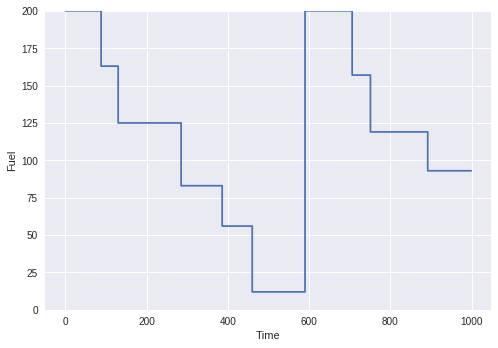

In [0]:
f, ax = plt.subplots(1, 1)
ax.step(obs_time, obs_fuel, where='post')
ax.set_ylabel('Fuel')
ax.set_ylim([0, max(obs_fuel)])
ax.set_xlabel('Time')
plt.show()

### E o tempo de espera até começar a abastecer?

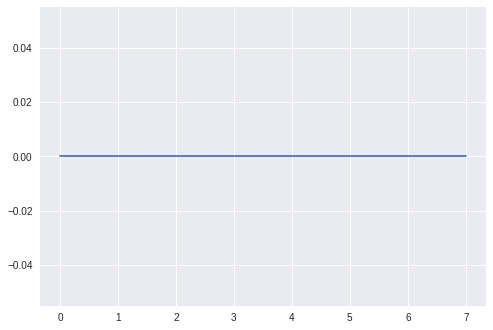

In [0]:
f, ax = plt.subplots(1, 1)
ax.plot(obs_wait)
plt.show()